In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os
import math

mp.verbosity(1)

SiO2 = mp.Medium(index=1.5*1.5)



# Constants
PI = np.pi

import math

# Constants
diameter = 5
a = 1.0
scale_down = 1

# Geometry properties
Lx = diameter / (a * scale_down)
Ly = 2.0 * Lx
resolution = 100
Lpml = 0.25

pml_layers = [mp.PML(thickness = Lpml,)]

# Position information
src_ypos = Ly - Lpml - 0.25
transmission_ypos = Lpml + 1.0


# Parameters of the Plano convex lens
d = (diameter / (a * scale_down)) / 2.0
focal = d * math.sqrt(21.0) / 2.0
r_cur = focal / (2 * a * scale_down)
sin_NA = d / math.sqrt(d * d + focal * focal)
k_airy = 2.0 * math.pi / 1.0
airy_NA = 0.38317 * Lx / 2.0
lens_ypos = src_ypos - 0.5
x_center = Lx / 2.0
y_center = lens_ypos + math.sqrt(r_cur * r_cur - d * d)


# source 설정
width = 0.1

fcen_red = 1/(0.65)
fwidth_red = fcen_red * width

fcen_green = 1/(0.55)
fwidth_green = fcen_green * width

fcen_blue = 1/(0.45)
fwidth_blue = fcen_blue * width

src_0 = mp.GaussianSource(frequency=fcen_red, fwidth=fwidth_red, is_integrated=True)

src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=fwidth_green, is_integrated=True)

src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=fwidth_blue, is_integrated=True)

source_center = [0, -9] # Source 위치
source_size = mp.Vector3(d*2)

source = [mp.Source(src_0, component=mp.Ez, size=source_size, center=source_center,)]


print(focal)
print(y_center)
print(lens_ypos)
print(r_cur)

5.7282196186948
10.397542485937368
9.0
2.8641098093474


     block, center = (-2.49,-6.51,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-2.48,-6.53,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-2.48,-6.52,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-2.48,-6.51,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-2.47,-6.55,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-2.47,-6.54,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,

<Axes: xlabel='X', ylabel='Y'>

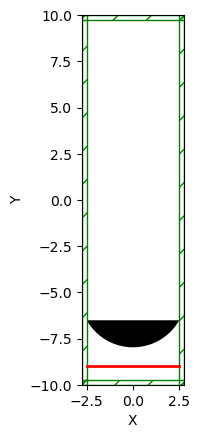

In [2]:
cell = mp.Vector3(d*2+Lpml*2,20)
# cell = mp.Vector3(10, 10)

geometry = [
    # mp.Block(
    #     center=mp.Vector3(y=lens_ypos-et/2), size=mp.Vector3(d*2,et), material=SiO2
    # )
]
for pos_x in np.arange(-20, 20, 0.01):
    for pos_y in np.arange(-20, 20, 0.01):
        if pos_y<=(lens_ypos):
            if ((pos_x-x_center)*(pos_x-x_center) + (pos_y-y_center)*(pos_y-y_center) <= (r_cur*r_cur)):
                geometry.append(mp.Block(center=mp.Vector3(pos_x -diameter/2, pos_y-diameter/2-13), size=mp.Vector3(0.5/resolution, 0.5/resolution), material=SiO2))
    
            
sim = mp.Simulation(
    cell_size=cell, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution,
)
sim.plot2D()

In [3]:
tran_Ex = sim.add_dft_fields([mp.Ex], fcen_red, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,20), yee_grid=True)
tran_Ey = sim.add_dft_fields([mp.Ey], fcen_red, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,20), yee_grid=True)
tran_Ez = sim.add_dft_fields([mp.Ez], fcen_red, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,20), yee_grid=True)
tran_Hx = sim.add_dft_fields([mp.Hx], fcen_red, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,20), yee_grid=True)
tran_Hy = sim.add_dft_fields([mp.Hy], fcen_red, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,20), yee_grid=True)
tran_Hz = sim.add_dft_fields([mp.Hz], fcen_red, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,20), yee_grid=True)
pt = mp.Vector3(0,lens_ypos-focal,0)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3)) 


-----------
Initializing structure...
time for choose_chunkdivision = 0.120766 s
Working in 2D dimensions.
Computational cell is 5.5 x 20 x 0 with resolution 100
     block, center = (-2.49,-6.51,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-2.48,-6.53,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-2.48,-6.52,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-2.48,-6.51,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-2.47,-6.55,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     

In [4]:
Ex_Namei="Ex_r_field"
Ey_Namei="Ey_r_field"
Ez_Namei="Ez_r_field"

Hx_Namei="Hx_r_field"
Hy_Namei="Hy_r_field"
Hz_Namei="Hz_r_field"



sim.output_dft(tran_Ex,str(diameter)+".0"+Ex_Namei)
sim.output_dft(tran_Ey,str(diameter)+".0"+Ey_Namei)
sim.output_dft(tran_Ez,str(diameter)+".0"+Ez_Namei)

sim.output_dft(tran_Hx,str(diameter)+".0"+Hx_Namei)
sim.output_dft(tran_Hy,str(diameter)+".0"+Hy_Namei)
sim.output_dft(tran_Hz,str(diameter)+".0"+Hz_Namei)

In [5]:
# total_flux0 = np.abs(sim.get_dft_array(tran_total0, mp.Ez, 0))**2


# plt.imshow(npa.rot90(total_flux0.reshape(diameter* resolution+1, diameter*2* resolution+1)))
# plt.colorbar()

In [6]:
sim.reset_meep()